# CLASIFICACIÓN CON XGBOOST EN PYTHON

## 1. El problema a resolver

El objetivo de esta práctica es crear, entrenar, validar y poner a prueba un modelo XGBOOST para realizar una tarea de clasificación, haciendo uso de Python y la librería Scikit-Learn.

En esta tarea de clasificación intentaremos predecir si a una persona se le otorgará o no un crédito con base en información asociada a su perfil (edad, género, nivel educativo, nivel de ingresos, etc.).

## 2. El set de datos

Usaremos el set de datos "dataset_prestamos_clasif.csv". Este es exactamente el mismo set de datos usado en la lección 6 del curso "Bosques Aleatorios", lección en la cual llevamos a cabo el pre-procesamiento de este set de datos.

Veamos en detalle el set de datos:

In [1]:
# Cargar dataset
import pandas as pd

RUTA = '/Users/miguel/Library/CloudStorage/GoogleDrive-miguel@codificandobits.com/My Drive/02-CODIFICANDOBITS.COM/04-Academia/01-Cursos/30-2024-12-XGBoost/data/'
df = pd.read_csv(RUTA + 'dataset_prestamos_clasif.csv')
df

,edad,genero,educacion,ingresos,annos_exp_laboral,propietario,prestamo_monto_solicitado,prestamo_uso,prestamo_tasa,prestamo_pctj_ing,annos_historial_crediticio,ptj_crediticio,impagos_previos,estado_prestamo
0,25.0,masculino,Universitario,63093.0,4,Propietario,6000.0,Negocio,11.01,0.10,4.0,632,Si,0
1,30.0,masculino,Escuela Secundaria,132825.0,6,Alquiler,3200.0,Personal,7.49,0.02,8.0,610,No,0
2,26.0,masculino,Especializacion,41744.0,5,Alquiler,10800.0,Salud,11.12,0.26,3.0,689,No,1
3,26.0,femenino,Escuela Secundaria,62487.0,4,Propietario,15000.0,AdecuacionesVivienda,6.92,0.24,2.0,618,Si,0
4,25.0,masculino,Universitario,46038.0,2,Alquiler,12500.0,PagoDeuda,18.62,0.27,3.0,643,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19633,29.0,masculino,Universitario,63127.0,10,Hipoteca,1900.0,Negocio,11.49,0.03,7.0,649,Si,0
19634,25.0,masculino,Maestria,37086.0,2,Alquiler,4000.0,Educacion,12.97,0.11,4.0,675,Si,0
19635,24.0,masculino,Universitario,31081.0,4,Alquiler,3200.0,PagoDeuda,13.11,0.10,4.0,633,No,1
19636,24.0,masculino,Universitario,180880.0,2,Hipoteca,20000.0,PagoDeuda,10.51,0.11,4.0,644,Si,0


En este caso las variables predictoras (o características, "features") serán las columnas:

- Edad
- Género
- Educación
- Ingresos
- Años de experiencia laboral
- Propietario
- Monto del préstamo solicitado
- Uso que se le dará al préstamo
- Tasa de interés
- Porcentaje de los ingresos que representa el préstamo
- Años de historial crediticio
- Puntaje crediticio
- Impagos previos

Y la idea es construir un modelo que prediga si al cliente se le otorgará (1) o no (0) un préstamo (columna "estado_prestamo").

Como el set de datos ya ha sido procesado no contiene ni datos faltantes ni valores extremos. Además se trata de un set de datos balanceado:

In [2]:
df['estado_prestamo'].value_counts()

estado_prestamo
0    9819
1    9819
Name: count, dtype: int64

## 3. Exploración del set de datos

Hagamos una exploración básica del set de datos, comenzando con las variables numéricas y haciendo uso de gráficos de caja:

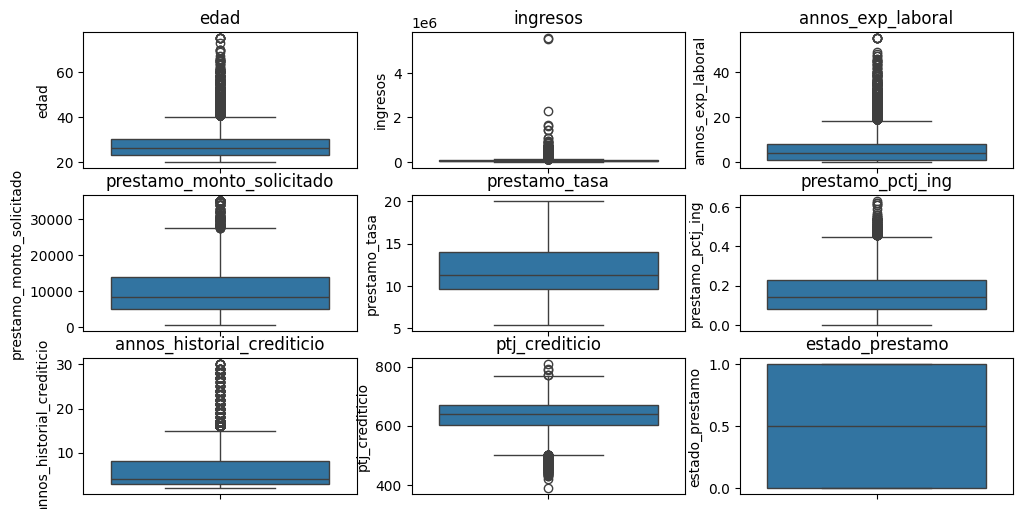

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cols_num = df.select_dtypes(include=np.number).columns

# Dibujar boxplots en grilla de 3x3
fig, axs = plt.subplots(3,3, figsize=(12,6))
axs = axs.flatten()

for i, col in enumerate(cols_num):
    sns.boxplot(df[col], ax=axs[i])
    axs[i].set_title(col)

Y ahora hagamos uso de gráficos de barras para analizar las variables categóricas:

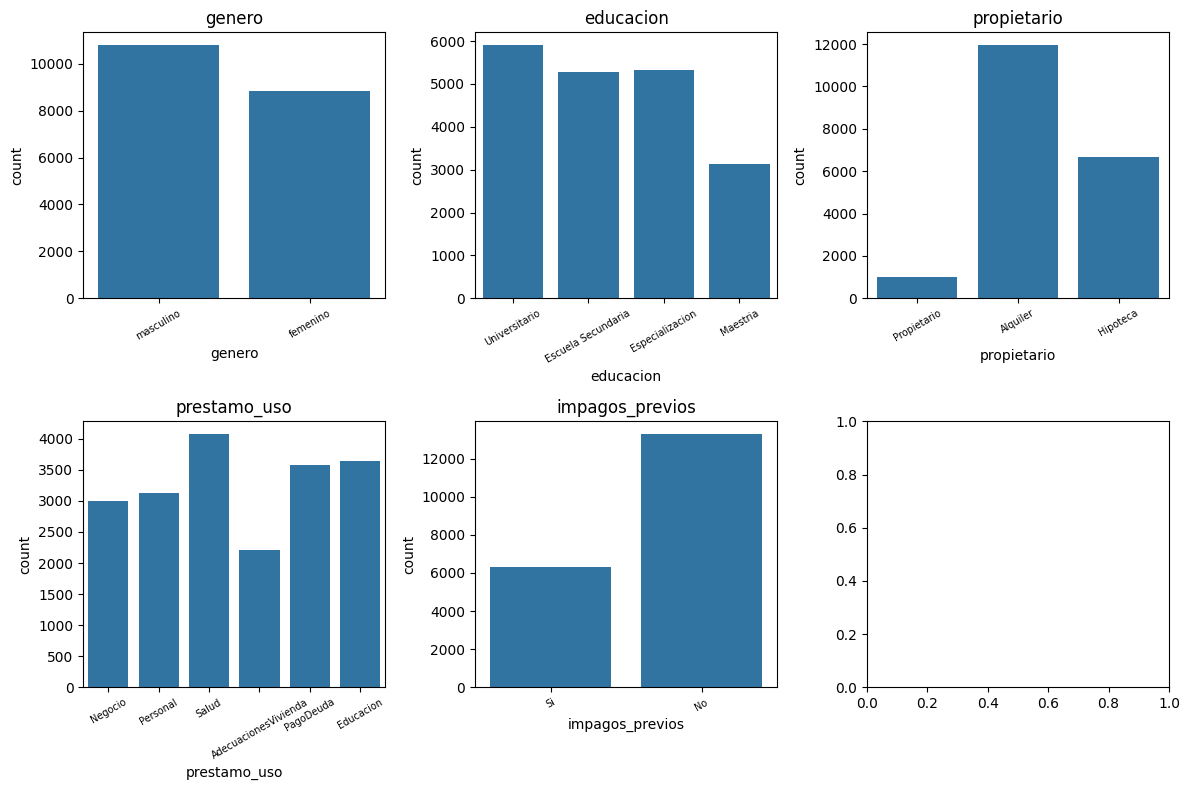

In [4]:
cols_cat = df.select_dtypes(include='object').columns

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(cols_cat):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)
    axs[i].tick_params(axis='x', rotation=30, labelsize=7)

# Ajustar distribución para que no se traslapen las gráficas
plt.tight_layout()

## 4. Pre-procesamiento de los datos

Generalmente, cuando implementamos por ejemplo modelos usando Scikit-Learn o librerías como Keras, TensorFlow o Pytorch, es necesario representar todas las variables de forma numérica.

Así por ejemplo, si tenemos una variable categórica como "impagos_previos", deberíamos codificarla usando el formato "one-hot":

- Sí -> [1, 0]
- No -> [0, 1]

En la librería XGBoost, además de esta opción, contamos con una opción adicional y es NO codificar las variables categóricas de forma numérica pero asignando el tipo de dato "category". Usaremos esta opción como parte del pre-procesamiento:

In [5]:
# DataFrame original
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19638 entries, 0 to 19637
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   edad                        19638 non-null  float64
 1   genero                      19638 non-null  object 
 2   educacion                   19638 non-null  object 
 3   ingresos                    19638 non-null  float64
 4   annos_exp_laboral           19638 non-null  int64  
 5   propietario                 19638 non-null  object 
 6   prestamo_monto_solicitado   19638 non-null  float64
 7   prestamo_uso                19638 non-null  object 
 8   prestamo_tasa               19638 non-null  float64
 9   prestamo_pctj_ing           19638 non-null  float64
 10  annos_historial_crediticio  19638 non-null  float64
 11  ptj_crediticio              19638 non-null  int64  
 12  impagos_previos             19638 non-null  object 
 13  estado_prestamo             196

In [6]:
# Representar las variables categóricas como tipo "category"
# (género, educación, propietario, prestamo_uso, impagos previos)

for col in cols_cat:
    df[col] = df[col].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19638 entries, 0 to 19637
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   edad                        19638 non-null  float64 
 1   genero                      19638 non-null  category
 2   educacion                   19638 non-null  category
 3   ingresos                    19638 non-null  float64 
 4   annos_exp_laboral           19638 non-null  int64   
 5   propietario                 19638 non-null  category
 6   prestamo_monto_solicitado   19638 non-null  float64 
 7   prestamo_uso                19638 non-null  category
 8   prestamo_tasa               19638 non-null  float64 
 9   prestamo_pctj_ing           19638 non-null  float64 
 10  annos_historial_crediticio  19638 non-null  float64 
 11  ptj_crediticio              19638 non-null  int64   
 12  impagos_previos             19638 non-null  category
 13  estado_prestamo 

Y ahora crearemos los sets de entrenamiento, validación y prueba, usando proporciones del 70%, 15% y 15% respectivamente:

In [7]:
from sklearn.model_selection import train_test_split

# Crear sets X y Y y partir dataset
X = df.iloc[:,:-1] # Características (variables predictoras)
Y = df.iloc[:,-1] # Variable a predecir

# Crear sets de entrenamiento, validación y prueba
x_tr, x_resto, y_tr, y_resto = train_test_split(X, Y, train_size=0.7, random_state=123)
x_vl, x_ts, y_vl, y_ts = train_test_split(x_resto, y_resto, test_size=0.5, random_state=123)

print('Tamaño set de entrenamiento: ' , x_tr.shape, y_tr.shape)
print('Tamaño set de validación: ', x_vl.shape, y_vl.shape)
print('Tamaño set de prueba: ', x_ts.shape, y_ts.shape)

Tamaño set de entrenamiento:  (13746, 13) (13746,)
Tamaño set de validación:  (2946, 13) (2946,)
Tamaño set de prueba:  (2946, 13) (2946,)


## 5. Creación y entrenamiento de un clasificador XGBoost

La sintaxis usada en XGBoost es muy similar a la usada al momento de implementar modelos de Scikit-Learn.

Sin embargo, como XGBoost contiene un elevado número de hiper-parámetros, lo mejor es definir inicialmente un diccionario que contendrá el listado de hiper-parámetros a usar (el listado completo de hiper-parámetros se encuentra en la documentación online de la librería:https://xgboost.readthedocs.io/en/stable/parameter.html).

A continuación definiremos este diccionario considerando los hiper-parámetros que generalmente tienen mayor impacto en el desempeño del modelo (en la lección 8 veremos cómo ajustar estos hiper-parámetros):

In [8]:
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic', # Clasificador binario
    'n_estimators': 100, # Número de árboles
    'random_state': 42, # Semilla del generador de números aleatorios
    'enable_categorical':True, # Para que el modelo procese variables categóricas
}

Y con esto ya podemos:

1. Crear una instancia del clasificador, presentándole los hiper-parámetros que acabamos de definir
2. Y entrenarlo usando el método "fit"

In [9]:
# Importar y crear modelo básico
from xgboost import XGBClassifier

modelo = XGBClassifier(**params)
modelo.fit(x_tr,y_tr)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

Y podemos ver el listado completo de hiper-parámetros usados para construir el modelo usando el método "get_params()":

In [10]:
modelo.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1,
 'lambda': 0}

## 6. Validación del modelo

El método "score" permite calcular la exactitud del modelo. Veamos cómo calcular este desempeño para entrenamiento y validación:

In [11]:
# Desempeño (exactitud) set de entrenamiento
tr_score = modelo.score(x_tr,y_tr)
print(f'Exactitud entrenamiento: {100*tr_score:.1f}%')

# Desempeño (exactitud) set de validación
vl_score = modelo.score(x_vl,y_vl)
print(f'Exactitud validación: {100*vl_score:.1f}%')

Exactitud entrenamiento: 93.5%
Exactitud validación: 90.6%


Sin embargo, la forma correcta de evaluar el desempeño del modelo es usando validación cruzada, donde:

![](https://scikit-learn.org/1.5/_images/grid_search_cross_validation.png)

1. Se subdivide el sub-set de entrenamiento en "k" partes (o *folds*)
2. El modelo se entrena k-1 veces con diferentes sub-sets y se prueba en la parte restante
3. Se repite el paso (2) k veces cambiando los sub-sets usados para entrenar y poner a prueba
4. Los desempeños se promedian para obtener una estimación del rendimiento del modelo

Veamos cómo implementar esta validación cruzada con XGBoost:

In [12]:
import xgboost as xgb

# Convertir el set de entrenamiento (x_tr, y_tr) al formato DMatrix usado por XGBoost
dtrain = xgb.DMatrix(data=x_tr, label=y_tr,
                     enable_categorical=True)

# Hiper-Parámetros
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic',
    # 'n_estimators': 100, # Número de árboles
    'random_state': 42, # Semilla del generador de números aleatorios
    # 'enable_categorical': True, # Para que el modelo procese variables categóricas
    'eval_metric': 'error', # Usar tasa de error (= 1 - exactitud) como métrica de desempeño
}

# Validación cruzada (5-fold) (no es necesario definir el tipo de modelo, este se infiere
# del hiper-parámetro "objective")
cv_res = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,            # Número de árboles a usar
    nfold=5,                        # Número de particiones
    seed=123,                       # Semilla generador aleatorio
    as_pandas=True                  # Retornar resultados como DataFrame de Pandas
)

cv_res

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.170104,0.004270,0.179106,0.003587
1,0.167303,0.004226,0.176706,0.004557
2,0.127819,0.003770,0.141569,0.007367
3,0.113815,0.001276,0.125055,0.002229
4,0.106431,0.001810,0.116761,0.002289
...,...,...,...,...
95,0.063164,0.001735,0.096900,0.005099
96,0.062509,0.001943,0.096464,0.005056
97,0.061909,0.001976,0.096318,0.004955
98,0.061363,0.002094,0.096246,0.005316


Cada fila corresponde al desempeño obtenido con el número de árboles correspondiente (1, 2, 3,..., 100). La columna "train-error-mean" contendrá el promedio de los desempeños con los "folds" de entrenamiento mientras que la columna "test-error-mean" contendrá el promedio de los desempeños con los "folds" de validación.

No necesariamente la última iteración será la mejor de todas (puede ser que 90 árboles funcionen mejor que 100). Así que para calcular el desempeño del modelo debemos:

1. Buscar la posición del mínimo error en la columna "test-error-min"
2. Extraer el desempeño para las columnas "train-error-mean" y "test-error-mean"

In [13]:
ronda_optima = cv_res['test-error-mean'].idxmin() # Número de árboles que arroja el menor error de prueba
mejor_ex_train = 1 - cv_res['train-error-mean'].iloc[ronda_optima]
mejor_ex_test = 1 - cv_res['test-error-mean'].iloc[ronda_optima]

# Imprimir resultados en pantalla
print(f'Número de árboles que arroja el mejor desempeño: {ronda_optima+1}')
print(f'Mejor exactitud entrenamiento: {100*mejor_ex_train:.1f}%')
print(f'Mejor exactitud prueba: {100*mejor_ex_test:.1f}%')


Número de árboles que arroja el mejor desempeño: 99
Mejor exactitud entrenamiento: 93.9%
Mejor exactitud prueba: 90.4%


## 7. Entrenamiento con parada temprana ("early stopping")

Como vimos anteriormente, XGBoost incluye, entre otras opciones, el entrenamiento con parada temprana.

La idea básica es simple:

> Se monitorea el desempeño del modelo durante el entrenamiento y sobre el set de validación y si el desempeño no mejora durante cierto número de iteraciones ("boosting rounds") entonces se detiene el entrenamiento.

Supongamos que queremos detener el entrenamiento si después de 10 iteraciones el desempeño no mejora. Para ello:

- Usaremos un número elevado de árboles como hiper-parámetro del modelo (por ejemplo 1.000)
- Definiremos el hiper-parámetro "early_stopping_rounds" con un valor de 10 (que serán las iteraciones a tener en cuenta para detener o continuar con el entrenamiento)

No importa si usamos un número elevado de árboles, pues probablemente el entrenamiento se detendrá antes de construir la totalidad de estos árboles.

Veamos esta implementación:

In [14]:
# Definir parámetros incluyendo early-stopping
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic',
    'n_estimators': 1000, # **** NÚMERO ELEVADO DE ÁRBOLES ****
    'early_stopping_rounds':10, # **** NÚMERO DE ITERACIONES EARLY STOPPING ****
    'random_state': 42, # Semilla del generador de números aleatorios
    'enable_categorical':True, # Para que el modelo procese variables categóricas
}

# Crear instancia del modelo con los hiper-parámetros especificados
modelo = XGBClassifier(**params)

# Entrenar el modelo con "fit" e indicarle cuáles serán los datos de validación
modelo.fit(x_tr, y_tr, eval_set=[(x_vl, y_vl)], verbose=True)

[0]	validation_0-logloss:0.64470
[1]	validation_0-logloss:0.60504
[2]	validation_0-logloss:0.55525
[3]	validation_0-logloss:0.51393
[4]	validation_0-logloss:0.47854
[5]	validation_0-logloss:0.44869
[6]	validation_0-logloss:0.42388
[7]	validation_0-logloss:0.40076
[8]	validation_0-logloss:0.38065
[9]	validation_0-logloss:0.36260
[10]	validation_0-logloss:0.34698
[11]	validation_0-logloss:0.33948
[12]	validation_0-logloss:0.33014
[13]	validation_0-logloss:0.31728
[14]	validation_0-logloss:0.30629
[15]	validation_0-logloss:0.29628
[16]	validation_0-logloss:0.29023
[17]	validation_0-logloss:0.28202
[18]	validation_0-logloss:0.27517
[19]	validation_0-logloss:0.27069
[20]	validation_0-logloss:0.26486
[21]	validation_0-logloss:0.25929
[22]	validation_0-logloss:0.25466
[23]	validation_0-logloss:0.25057
[24]	validation_0-logloss:0.24624
[25]	validation_0-logloss:0.24406
[26]	validation_0-logloss:0.24022
[27]	validation_0-logloss:0.23672
[28]	validation_0-logloss:0.23477
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, ...)

En el caso anterior vemos que a pesar de haber definido un total de 1.000 árboles, el entrenamiento se detiene cuando el modelo alcanza aproximadamente 167 árboles.

En el caso anterior, la métrica de desempeño de referencia usada para el "early stopping" fue la misma perdida "log-loss". Podemos hacerlo con cualquier otra métrica, por ejemplo la tasa de error:

In [15]:
# Definir parámetros incluyendo early-stopping
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic',
    'n_estimators': 1000, # **** NÚMERO ELEVADO DE ÁRBOLES ****
    'early_stopping_rounds':10, # **** NÚMERO DE ITERACIONES EARLY STOPPING ****
    'eval_metric': 'error', # **** MÉTRICA DE DESEMPEÑO QUE SE USARÁ COMO REFERENCIA PARA EL EARLY STOPPING****
    'random_state': 42, # Semilla del generador de números aleatorios
    'enable_categorical':True, # Para que el modelo procese variables categóricas
}

# Crear instancia del modelo con los hiper-parámetros especificados
modelo = XGBClassifier(**params)

# Entrenar el modelo con "fit" e indicarle cuáles serán los datos de validación
modelo.fit(x_tr, y_tr, eval_set=[(x_vl, y_vl)], verbose=True)

[0]	validation_0-error:0.18262
[1]	validation_0-error:0.17447
[2]	validation_0-error:0.13510
[3]	validation_0-error:0.12424
[4]	validation_0-error:0.11847
[5]	validation_0-error:0.11711
[6]	validation_0-error:0.11303
[7]	validation_0-error:0.11371
[8]	validation_0-error:0.11134
[9]	validation_0-error:0.11202
[10]	validation_0-error:0.11168
[11]	validation_0-error:0.11202
[12]	validation_0-error:0.11100
[13]	validation_0-error:0.10998
[14]	validation_0-error:0.11066
[15]	validation_0-error:0.10930
[16]	validation_0-error:0.10998
[17]	validation_0-error:0.10828
[18]	validation_0-error:0.10625
[19]	validation_0-error:0.10692
[20]	validation_0-error:0.10692
[21]	validation_0-error:0.10828
[22]	validation_0-error:0.10930
[23]	validation_0-error:0.10828
[24]	validation_0-error:0.10659
[25]	validation_0-error:0.10659
[26]	validation_0-error:0.10659
[27]	validation_0-error:0.10692
[28]	validation_0-error:0.10591
[29]	validation_0-error:0.10489
[30]	validation_0-error:0.10625
[31]	validation_0-

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=True, eta=0.1, eval_metric='error',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, ...)

Y en este caso el entrenamiento se detiene tras entrenar aproximadamente 96 árboles.

Y podemos usar el "early-stopping" como parte del proceso de validación cruzada:

In [16]:
# Convertir el set de entrenamiento (x_tr, y_tr) al formato DMatrix usado por XGBoost
dtrain = xgb.DMatrix(data=x_tr, label=y_tr,
                     enable_categorical=True)

# Hiper-Parámetros
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic',
    'random_state': 42, # Semilla del generador de números aleatorios
    'eval_metric': 'error', # Usar tasa de error (= 1 - exactitud) como métrica de desempeño
}

# Validación cruzada (5-fold) (no es necesario definir el tipo de modelo, este se infiere
# del hiper-parámetro "objective")
cv_res = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,           # Definir inicialmente un número elevado de árboles
    nfold=5,                        # Número de particiones
    seed=123,                       # Semilla generador aleatorio
    early_stopping_rounds=10,       # **** HIPER-PARÁMETROS EARLY STOPPING ****
    as_pandas=True                  # Retornar resultados como DataFrame de Pandas
)

cv_res

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.170104,0.004270,0.179106,0.003587
1,0.167303,0.004226,0.176706,0.004557
2,0.127819,0.003770,0.141569,0.007367
3,0.113815,0.001276,0.125055,0.002229
4,0.106431,0.001810,0.116761,0.002289
5,0.102775,0.001663,0.115670,0.003183
6,0.098429,0.001713,0.110432,0.003158
7,0.098101,0.001873,0.110941,0.002648
8,0.097574,0.001808,0.111305,0.003015
9,0.097337,0.001637,0.110359,0.002641


Y vemos que tras entrenar 47 árboles el entrenamiento se detiene. En este punto podemos imprimir en pantalla el desempeño obtenido con entrenamiento/validación, donde el mejor desempeño corresponderá a la última iteración:

In [17]:
mejor_ex_train = 1 - cv_res['train-error-mean'].iloc[-1]
mejor_ex_test = 1 - cv_res['test-error-mean'].iloc[-1]

# Imprimir resultados en pantalla
print(f'Mejor exactitud entrenamiento: {100*mejor_ex_train:.1f}%')
print(f'Mejor exactitud prueba: {100*mejor_ex_test:.1f}%')

Mejor exactitud entrenamiento: 91.7%
Mejor exactitud prueba: 90.1%


## 8. Generación de predicciones

Esta es la parte más sencilla. Simplemente, después de entrenar el modelo usamos el método "predict" y le presentamos las variables predictoras del set de datos a partir del cual queremos generar las predicciones:

In [18]:
# Entrenar el modelo con Early Stopping

# Definir parámetros incluyendo early-stopping
params = {
    'booster': 'gbtree', # Usar gradient boosting trees
    'eta': 0.1, # Tasa de aprendizaje
    'gamma': 0, # Parámetro 𝜸
    'lambda': 0, # Parámetro λ
    'max_depth': 6, # Máxima profundidad del árbol
    'colsample_bytree': 0.8, # Porcentaje de muestreo de las columnas
    'objective': 'binary:logistic',
    'n_estimators': 1000, # **** NÚMERO ELEVADO DE ÁRBOLES ****
    'early_stopping_rounds':10, # **** NÚMERO DE ITERACIONES EARLY STOPPING ****
    'random_state': 42, # Semilla del generador de números aleatorios
    'enable_categorical':True, # Para que el modelo procese variables categóricas
}

# Crear instancia del modelo con los hiper-parámetros especificados
modelo = XGBClassifier(**params)

# Entrenar el modelo con "fit" e indicarle cuáles serán los datos de validación
modelo.fit(x_tr, y_tr, eval_set=[(x_vl, y_vl)], verbose=True)


[0]	validation_0-logloss:0.64470
[1]	validation_0-logloss:0.60504
[2]	validation_0-logloss:0.55525
[3]	validation_0-logloss:0.51393
[4]	validation_0-logloss:0.47854
[5]	validation_0-logloss:0.44869
[6]	validation_0-logloss:0.42388
[7]	validation_0-logloss:0.40076
[8]	validation_0-logloss:0.38065
[9]	validation_0-logloss:0.36260
[10]	validation_0-logloss:0.34698
[11]	validation_0-logloss:0.33948
[12]	validation_0-logloss:0.33014
[13]	validation_0-logloss:0.31728
[14]	validation_0-logloss:0.30629
[15]	validation_0-logloss:0.29628
[16]	validation_0-logloss:0.29023
[17]	validation_0-logloss:0.28202
[18]	validation_0-logloss:0.27517
[19]	validation_0-logloss:0.27069
[20]	validation_0-logloss:0.26486
[21]	validation_0-logloss:0.25929
[22]	validation_0-logloss:0.25466
[23]	validation_0-logloss:0.25057
[24]	validation_0-logloss:0.24624
[25]	validation_0-logloss:0.24406
[26]	validation_0-logloss:0.24022
[27]	validation_0-logloss:0.23672
[28]	validation_0-logloss:0.23477
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, ...)

In [19]:
# Y ahora generamos predicciones sobre el set de prueba
modelo.predict(x_ts)

array([1, 0, 0, ..., 0, 1, 0], shape=(2946,))